### 📈 Time-Series Summarization & Trend Analysis of Power System Faults

In this notebook, we explore **time-series summarization** and **trend analysis** using the Power System Faults Dataset.

**Time-Series Summarization**:
- Aggregates data by time intervals (e.g., day, week, month).
- Computes summary statistics: mean, median, total, etc.
- Helps simplify and detect patterns in large datasets.

**Trend Analysis**:
- Identifies long-term increases or decreases in metrics over time.
- Helps uncover seasonal patterns and irregularities in time-series data.


***
### 📥 Load the dataset from URL

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/fault_data.csv'
df = pd.read_csv(url)

df.head()

,Fault ID,Fault Type,"Fault Location (Latitude, Longitude)",Voltage (V),Current (A),Power Load (MW),Temperature (C),Wind Speed (km/h),Weather Condition,Maintenance Status,Component Health,Duration of Fault (hrs),Down time (hrs)
0,F001,Line Breakage,"(34.0522, -118.2437)",2200,250,50,25,20,Clear,Scheduled,Normal,2.0,1.0
1,F002,Transformer Failure,"(34.056, -118.245)",1800,180,45,28,15,Rainy,Completed,Faulty,3.0,5.0
2,F003,Overheating,"(34.0525, -118.244)",2100,230,55,35,25,Windstorm,Pending,Overheated,4.0,6.0
3,F004,Line Breakage,"(34.055, -118.242)",2050,240,48,23,10,Clear,Completed,Normal,2.5,3.0
4,F005,Transformer Failure,"(34.0545, -118.243)",1900,190,50,30,18,Snowy,Scheduled,Faulty,3.5,4.0


In [2]:
# # Load dataset
# df = pd.read_csv("data/fault_data.csv")

# # Display initial records
# df.head()

#### 🕒 Step 1: Simulate Fault Dates for Time-Series Analysis

In [3]:
# Simulate one fault per day starting from 2023-01-01
df['Fault Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')

# Set as datetime index
df['Fault Date'] = pd.to_datetime(df['Fault Date'])
df.set_index('Fault Date', inplace=True)
df.index.name = "Date"

df[['Fault Type', 'Duration of Fault (hrs)', 'Down time (hrs)']].head()

,Fault Type,Duration of Fault (hrs),Down time (hrs)
Date,,,
2023-01-01,Line Breakage,2.0,1.0
2023-01-02,Transformer Failure,3.0,5.0
2023-01-03,Overheating,4.0,6.0
2023-01-04,Line Breakage,2.5,3.0
2023-01-05,Transformer Failure,3.5,4.0


#### 🗂️ Step 2: Time-Series Summarization

In [4]:
# Weekly downtime sum
weekly_downtime = df['Down time (hrs)'].resample('W').sum()

# Monthly duration mean
monthly_duration = df['Duration of Fault (hrs)'].resample('ME').mean()

# Monthly fault count
monthly_faults = df['Fault Type'].resample('ME').count()

#### 📊 Step 3: Visualize Summarized Trends

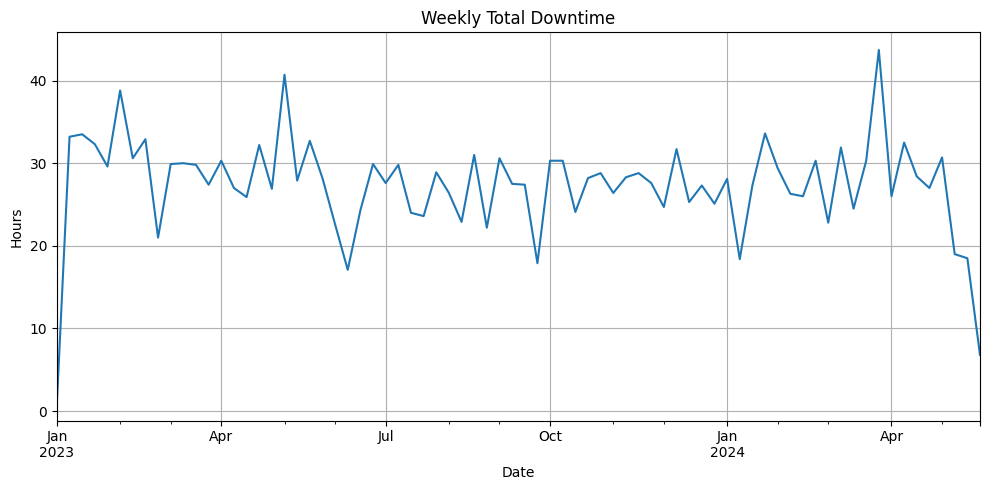

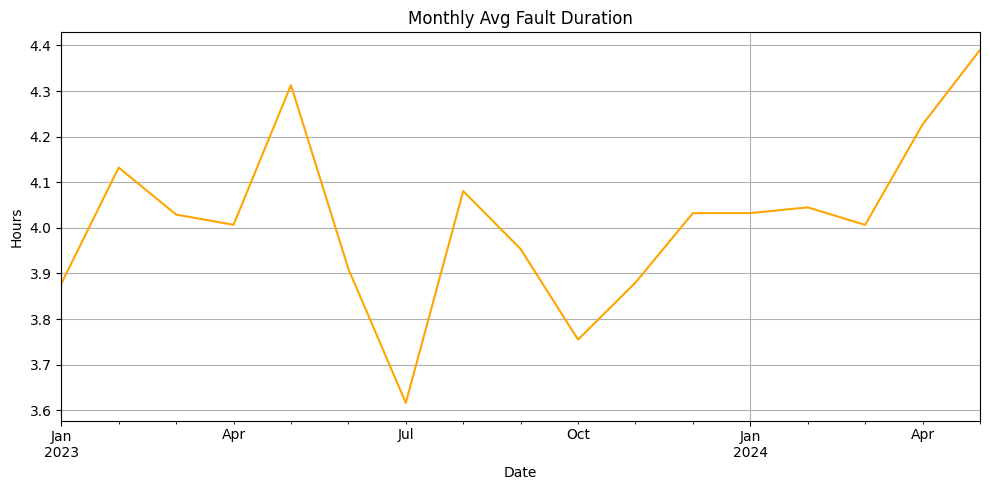

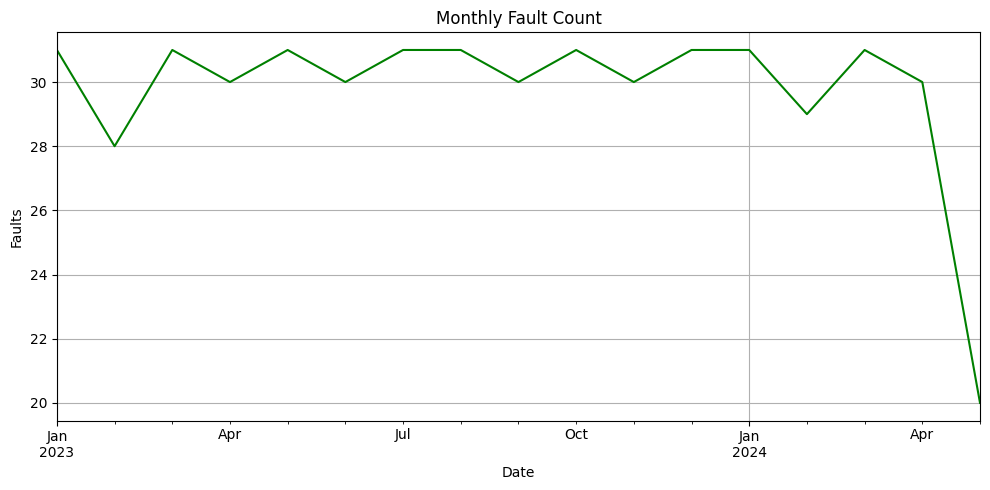

In [5]:
import matplotlib.pyplot as plt

# Weekly downtime
plt.figure(figsize=(10,5))
weekly_downtime.plot(title="Weekly Total Downtime", ylabel="Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly duration
plt.figure(figsize=(10,5))
monthly_duration.plot(color='orange', title="Monthly Avg Fault Duration", ylabel="Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly fault count
plt.figure(figsize=(10,5))
monthly_faults.plot(color='green', title="Monthly Fault Count", ylabel="Faults")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 🔍 Step 4: Trend Decomposition

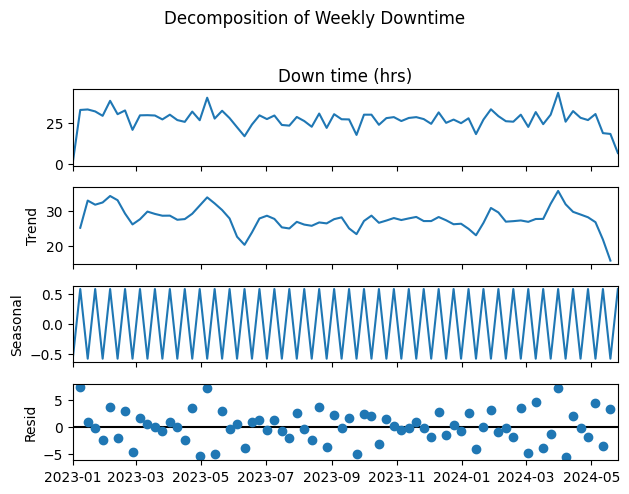

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Fill missing values if any
weekly_downtime_filled = weekly_downtime.interpolate()

# Decompose
result = seasonal_decompose(weekly_downtime_filled, model='additive', period=2)
result.plot()
plt.suptitle("Decomposition of Weekly Downtime", y=1.02)
plt.tight_layout()
plt.show()

#### ⏱️ Time-Based Analysis: Duration vs Down Time

We investigate the relationship between:

- **Duration of Fault (hrs)** ⏳  
- **Down time (hrs)** 🔧  

A **scatter plot with a regression line** is used to visualize potential correlations and patterns.

🔍 This analysis helps answer:
- Does longer fault duration lead to proportionally more downtime?
- Are there any outliers where downtime is disproportionately high or low?

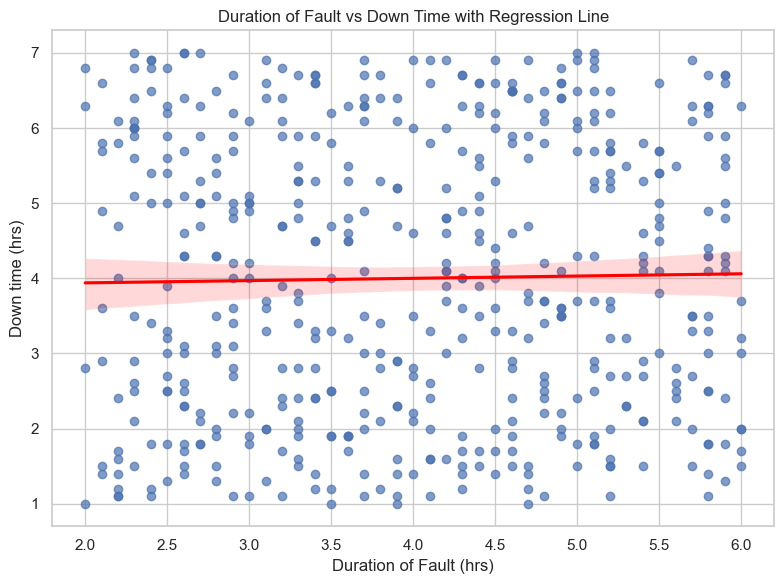

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.regplot(
    x='Duration of Fault (hrs)', 
    y='Down time (hrs)', 
    data=df,
    scatter_kws={'alpha':0.7},
    line_kws={'color':'red'}
)

plt.title("Duration of Fault vs Down Time with Regression Line")
plt.xlabel("Duration of Fault (hrs)")
plt.ylabel("Down time (hrs)")
plt.grid(True)
plt.tight_layout()
plt.show()